# 商業與大數據分析
    NLP語意分析實作
- 資料集：2021年所有有關跌停、漲停的新聞報導 (因為2021年股市大熱因此83%為漲停)
- 任務
    1. 找出具有鑑別力的200個詞彙
    2. 「以文找文」給定一段文字/一篇報導，找出最相似的報導
    3. 利用監督式學習建立文章自動分類器，給定文字->判斷漲停or跌停
- 羅奕丞 2022/3/23

# 各列出100個詞彙漲停及跌停文件中最具鑑別力的詞彙
    這裡採 「出現頻率」 做為鑑別力高低的評判標準

In [1]:
import monpa
from collections import defaultdict
import itertools 
import pandas as pd
import numpy as np

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


In [2]:
import csv
documents = []
with open(r'C:\Users\Yicheng\Desktop\NTU\110-2\Bigdata Business Analysis\bda2022_hw2_text\limit_up.csv', newline='', encoding="utf-8") as csvfile:
     spamreader = csv.reader(csvfile)
     next(spamreader)  # 跳過第一行
     for row in spamreader:
         documents.append(row)  # 漲停共有612個漲停document
with open(r'C:\Users\Yicheng\Desktop\NTU\110-2\Bigdata Business Analysis\bda2022_hw2_text\limit_down.csv', newline='', encoding="utf-8") as csvfile:
     spamreader = csv.reader(csvfile)
     next(spamreader)  # 跳過第一行
     for row in spamreader:
         documents.append(row)  # 跌停共有126個跌停document



In [3]:
# Title轉換成漲停與否的0,1變數，也就是之後要預測的Y
documents_title = []
for i in range(len(documents)):
    documents_title.append(documents[i][0])  # 把標題存起來，以便找出相似度文章後索引
    if '漲停' in documents[i][0]:
        documents[i][0] = 1
    else:
        documents[i][0] = 0
        

In [4]:
# 長句截成短句再使用monpa斷句，否則會遺失token
def LongCut(long_sentence, split_char):
    seg = []
    for item in long_sentence.split(split_char):
        if item != "\n": seg.extend(monpa.cut(f'{item}{split_char}'))
    return seg[:-1]

# 每篇的斷詞結果，存成一個Nestlist: tokens
documents_token = [LongCut(document[1], '，') for document in documents] # Runtime: 4m 4.6s

# len(documents_token) 
# 738

C:\Users\Yicheng\anaconda3\lib\site-packages\monpa\crf_layer.py:374: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorCompare.cpp:333.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


+ 接下來移除長度為1的token

In [5]:
for i in range(len(documents_token)):
    documents_token[i] = list(
        filter(lambda token: len(token) >= 2, documents_token[i]))


- 建立語料庫(corpus)，使用gensim套件

In [6]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
dictionary = Dictionary(documents_token)
# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(document_token) for document_token in documents_token]

In [7]:
# Create the defaultdict: up_word_count
up_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus[:613]):  # itertools.chain是為了讓我們能夠把整個corpus清單視為一整個連續的list(本來裡面有612個子list)
    up_word_count[word_id] += word_count
    
# Create a sorted list from the defaultdict: sorted_word_count
sorted_up_word_count = sorted(up_word_count.items(), key=lambda w: w[1], reverse=True) 

# Store TOP 100 token for up
top100_up_token = [(ids, freq) for ids, freq in sorted_up_word_count[:100]]
print(top100_up_token[:5])


# Create the defaultdict: down_word_count
down_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus[613:]):
    down_word_count[word_id] += word_count
    
# Create a sorted list from the defaultdict: sorted_word_count
sorted_down_word_count = sorted(down_word_count.items(), key=lambda w: w[1], reverse=True) 

# Store TOP 100 token for down
top100_down_token = [(ids, freq) for ids, freq in sorted_down_word_count[:100]]
print(top100_down_token[:5])

[(285, 886), (309, 822), (132, 759), (378, 671), (92, 603)]
[(3081, 251), (309, 222), (92, 155), (1057, 138), (56, 135)]


# 實作「以文找文」的功能
    ● 直接應用上課教的簡易方法，求兩向量cosine
    ● 為了方便測試\query其他文章報導，因此直接定義一個找前3個相似度最高的報導的函數
    ● 測試將文章複製兩倍長，結果cosine相同，表示在tfidfModel時有作Length normalization
- 以選出來的200個keyword重新篩選每篇文章的tokens

In [8]:
# Find the TOP200 keywords
keyword200 = [dictionary.get(ids) for ids, freq in (top100_up_token + top100_down_token)]

# Filter the original token, select those in TOP200 keywords
documents_token_200 = []
for document in documents_token:
    document_token_200 = list(filter(lambda token: token in keyword200, document))
    documents_token_200.append(document_token_200)

- 下一步是建立Dictionary & Tfidf模型，將每篇報導轉成向量空間

In [9]:
# Create new dictionary
dictionary_200 = Dictionary(documents_token_200)

# Create a MmCorpus: corpus
corpus_200 = [dictionary_200.doc2bow(document_token_200) for document_token_200 in documents_token_200]

# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus_200)

# Create Document Vector
n_items = len(dictionary_200)
corpus_200_tfidf = tfidf[corpus_200]
documents_space = []
for doc in corpus_200_tfidf:
    d = [0] * n_items
    for index, value in doc :
        d[index] = value
    documents_space.append(d)


+ 定義找相似度最高前三篇報導的函數

In [10]:
def get_query_tfidf(query):
    '''To find the [(index, tfidf_value)] for this query'''
    query_token = LongCut(query, '，')
    for i in range(len(query_token)):
        query_token = list(
            filter(lambda token: len(token) >= 2, query_token)
            )
    query_corpus = dictionary_200.doc2bow(query_token)
    tfidf_query_weight = tfidf[query_corpus]
    return tfidf_query_weight

def TOP3_similarity(query):
    '''Use this function to find out the most similar document on the query we input
    tokenize, filter, calculate cosine, sort the outcome.
    '''
    tfidf_query_weight = get_query_tfidf(query)
    similarity_list = []
    for document in range(len(documents_space)):
        cosine = 0
        for index, value in tfidf_query_weight:
            cosine += value * documents_space[document][index]
        similarity_list.append([document, cosine])
            
    similarity_list_ordered = sorted(similarity_list, key = lambda x: x[1], reverse=True)

    return similarity_list_ordered[:3]

In [11]:
query = '''半導體股12日回神，蘋果股價創歷史新高，蘋果鏈龍頭指標股台積電15日法說會在即，股價應聲大漲9元收593元，外資回頭狂加碼，激勵半導體四強—台積電、聯發科、日月光投控及聯電股價聯袂大漲，更有千金股祥碩亮燈漲停領軍、共14檔中小型半導體股飆漲停。美國費城半導體指數9日收漲1.72％，是四大指數中表現最強，台積電ADR更反彈2.28％，激勵台股12日開盤後，股價就直接跳空大漲，半導體重量級指標股一片紅通通，帶動半導體類股指數最後收漲1.8％，成為電子股上漲1.36％最佳助攻手。上市半導體股共75檔個股，除了台積電單一個股市值增長貢獻2,333.8億元之外，整體上市半導體股市值回升3,731億元；個股就有祥碩、威鋒電子、菱生、華東、愛普、凌通、盛群、晶心科、凌陽、強茂、同欣電、迅杰、矽統、界霖等14檔飆漲停。統一投顧董事長黎方國指出，蘋果股價9日創歷史新高，激勵蘋概股股價走強，加上下半年為電子旺季，市場關注台積電15日法說會內容可能偏正向，隨著傳產股漲多之後，帶動資金從傳產股回流，預期未來台股成交量能會均衡在電子與傳產之間。台股12日成交值5,588億元，電子股成交值2,425億元，惟電子股成交值比重仍僅有43％多；若聚焦看半導體股成交值為1,395億元、占比約25％。台新投顧副總黃文清指出，近日市場資金尚未真正重返權值電子股，由中小型電子尖兵領頭，不少個股股價不是漲停就是創新高。多位投資專家已將目光重回電子股，但認為目前電子股反彈氣勢仍不夠，成交值占比至少要重回五成以上，才可望重回主流，成交值要達到六～七成才有攻擊力道，因而，短線仍觀察資金消長。黎方國認為，電子五強台積電、聯發科、鴻海、大立光及台達電等，目前股價位階都尚屬偏低，與前一波高點相較都還有很大落差，目前技術線型仍然偏弱，未來有待資金重返。'''
# query = '''半導體股12日回神，蘋果股價創歷史新高，蘋果鏈龍頭指標股台積電15日法說會在即，股價應聲大漲9元收593元，外資回頭狂加碼，激勵半導體四強—台積電、聯發科、日月光投控及聯電股價聯袂大漲，更有千金股祥碩亮燈漲停領軍、共14檔中小型半導體股飆漲停。美國費城半導體指數9日收漲1.72％，是四大指數中表現最強，台積電ADR更反彈2.28％，激勵台股12日開盤後，股價就直接跳空大漲，半導體重量級指標股一片紅通通，帶動半導體類股指數最後收漲1.8％，成為電子股上漲1.36％最佳助攻手。上市半導體股共75檔個股，除了台積電單一個股市值增長貢獻2,333.8億元之外，整體上市半導體股市值回升3,731億元；個股就有祥碩、威鋒電子、菱生、華東、愛普、凌通、盛群、晶心科、凌陽、強茂、同欣電、迅杰、矽統、界霖等14檔飆漲停。統一投顧董事長黎方國指出，蘋果股價9日創歷史新高，激勵蘋概股股價走強，加上下半年為電子旺季，市場關注台積電15日法說會內容可能偏正向，隨著傳產股漲多之後，帶動資金從傳產股回流，預期未來台股成交量能會均衡在電子與傳產之間。台股12日成交值5,588億元，電子股成交值2,425億元，惟電子股成交值比重仍僅有43％多'''

# https://www.chinatimes.com/newspapers/20210713000122-260202?chdtv

TOP3_similarity(query)
for index, value in TOP3_similarity(query)[:3]:
    print('最相似報導: {} \t similarity: {}'.format(documents_title[index], value))

# 最相似報導: 《各報要聞》半導體股 14檔飆漲停 	 similarity: 0.9929300617251932
# 最相似報導: 台積電領軍台股端午後攻高 高端漲跌停一瞬間 	 similarity: 0.5890672303850195
# 最相似報導: 《盤後解析》台積振作、萬海漲停 台股守住萬七 	 similarity: 0.5869290917528419

最相似報導: 《各報要聞》半導體股 14檔飆漲停 	 similarity: 0.9942127852796526
最相似報導: 《台北股市》權王轉填息、華碩飆漲停 快攻16300關 	 similarity: 0.5379826264014862
最相似報導: 台積電領軍台股端午後攻高 高端漲跌停一瞬間 	 similarity: 0.5272127789801117


# 實作「文件自動標記」的分類功能
    ● Multinomial Naive Bayes
    ● Support Vector Machine
    ● k-Nearest Neighbor
    ● LogisticRegression
    ● Decision Tree

In [12]:
# Create column name for DF
token_name = []
for index in range(n_items):
    token_name.append(dictionary_200.get(index))

# Build DF
dfidf_df = pd.DataFrame(documents_space, columns=token_name)

- 拆分訓練與測試資料集

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, classification_report
from sklearn import metrics

y_array = np.array(documents)
y = y_array[:,0].astype('int')
X_train, X_test, y_train, y_test = train_test_split(dfidf_df, y, test_size=0.33, random_state=42)

- 比較不同分類器的優劣程度 (交叉驗證、計算Accuracy)

In [14]:
from sklearn.model_selection import cross_val_score

def get_cvscore(classifier,X,y,cv=5,scoring='accuracy'):
    '''return scores, Avg score'''
    scores = cross_val_score(classifier,X,y,cv=cv,scoring=scoring)
    print(scores)
    print("Avg. Accuracy: {}".format(scores.mean()))

In [15]:
from sklearn.metrics import roc_auc_score
def fit_model(classifier, X_train, y_train, y_test):
    '''We fit model and return fpr, tpr, y_pred'''
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_train)
    y_pred_prob = classifier.predict_proba(X_test)[:,1]
    print('Accuracy: {}'.format(classifier.score(X_test, y_test)))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    return fpr, tpr, y_pred

In [16]:
# 定義繪製ROC Curve的函數
import matplotlib.pyplot as plt
def plot_ROC_Curve(fpr, tpr):
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

- Multinomial Naive bayes Model

In [28]:
from sklearn.naive_bayes import MultinomialNB
Multi_nb = MultinomialNB()
get_cvscore(Multi_nb, X_train, y_train, cv=5, scoring='accuracy')

[0.87878788 0.88888889 0.90909091 0.88888889 0.87755102]
Avg. Accuracy: 0.8886415172129458


- SVC

In [18]:
# SVM
from sklearn.svm import SVC
svm = SVC(kernel='linear')
get_cvscore(svm , X_train, y_train, cv=5, scoring='accuracy')

[0.90909091 0.8989899  0.91919192 0.8989899  0.86734694]
Avg. Accuracy: 0.8987219130076273


- KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
get_cvscore(knn , X_train, y_train, cv=5, scoring='accuracy')

[0.84848485 0.86868687 0.91919192 0.84848485 0.83673469]
Avg. Accuracy: 0.8643166357452072


- Logistic Regression

In [20]:
# Logistic Regre
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression().fit(X_train, y_train)
get_cvscore(log_reg , X_train, y_train, cv=5, scoring='accuracy')

[0.87878788 0.84848485 0.88888889 0.86868687 0.84693878]
Avg. Accuracy: 0.8663574520717378


- Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier                          
decisiontree = DecisionTreeClassifier(criterion="entropy")
get_cvscore(decisiontree , X_train, y_train, cv=5, scoring='accuracy')

[0.93939394 0.97979798 0.98989899 0.95959596 0.96938776]
Avg. Accuracy: 0.9676149247577819


# 使用Decision Tree 作為我們文件自動分類的Model

Accuracy of decisiontree: 0.9795081967213115


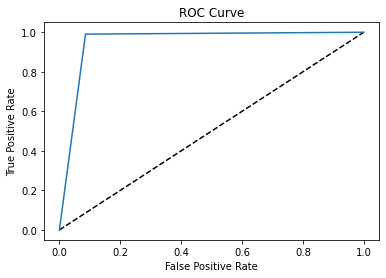

AUC: 0.9523581681476417
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.99      0.99      0.99       209

    accuracy                           0.98       244
   macro avg       0.96      0.95      0.96       244
weighted avg       0.98      0.98      0.98       244

[[ 32   3]
 [  2 207]]


In [22]:
decisiontree.fit(X_train, y_train)
y_pred = decisiontree.predict(X_test)
y_pred_prob = decisiontree.predict_proba(X_test)[:,1]
print('Accuracy of decisiontree: {}'.format(decisiontree.score(X_test, y_test)))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot AUC Curve
plot_ROC_Curve(fpr, tpr)

# AUC
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# classification_report
print(classification_report(y_test, y_pred))

# confusion_matrix
from sklearn.metrics import confusion_matrix  
print(confusion_matrix(y_test, y_pred)) #印出混淆矩陣
# test/predicted 看跌   看漲
#    看跌         TN     FP
#    看漲         FN     TP


In [ ]:
# 只取年月日的時間格式
df_stocks.index = pd.to_datetime(df_stocks.index.date)
df_news.index = pd.to_datetime(df_news.index.date)

- 給定任何內容進行預測

In [23]:
#給定任何一段內容當作查詢
query1='PC品牌大廠華碩（2357）今（16）日舉行線上法說會，受惠顯示卡及PC需求暢旺，\
  帶動華碩去年品牌毛利率、營益率、淨利率「三率三升」，稅後純益大增68%，創下歷史新高，\
  全年每股純益（EPS）達60元，大賺近6個股本。華碩今日公布去年品牌財報，毛利率20.3%，\
  年增3.1個百分點。營益率9.6%，年增3個百分點。稅後純益445.5億元，年增68%。\
  淨利率8.9%，年增2個百分點。全年每股純益達60元'
query2='台股加權指數在最近9個交易日，從最高到最低點，跌了2,544點，創下史上最快速的失速列車紀錄；\
  12日台股盤中急挫1,418點，市場衰鴻遍野，據統計，盤中最多曾有711檔個股觸及跌停、占上市櫃的四成比重，\
  最後仍有251檔收跌停，其中，陽明等15檔股價亮燈跌停，仍有7千張以上賣單高掛，貨櫃三雄均入榜。'


In [24]:
def predict_document(classifier, query):
    '''Predict the query for up or down'''
    d = [0] * n_items
    for index, value in get_query_tfidf(query) :
        d[index] = value
    X = pd.DataFrame([d], columns=token_name) #將q印出做觀察
    y_pred = classifier.predict(X) #預測
    return y_pred

In [25]:
pred_1 = predict_document(decisiontree, query1)
pred_2 = predict_document(decisiontree, query2)
print(pred_1, pred_2)

[1] [0]
